## Santander Customer Transactions predictions

#BigDataSets#HighDimensionality#DataBalancing

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta  
import os
import random
import scipy as sp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

import seaborn as sns; sns.set()

In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from functions import scaler, threeD_plot, mahalanobis, mahalanobis_vector_plot, compute_mahalanobis_parts , normal_augmentation, concentrated_augmentation
from functions import augmentation_strategy, augmentation_selection_rates, metrics_train_validation, balance_validation, partitions
from functions import unscaler, k_folds_indexs, model_fitting_kfold, weighting_models, jsontotable, plot_results, reconstructing_data

In [5]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score,accuracy_score,roc_auc_score, roc_curve, auc

### Loading Data

In [6]:
train = pd.read_csv('train.csv')
ss = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')

In [7]:
['var_4', 'var_12', 'var_46', 'var_78', 'var_81', 'var_110', 'var_152', 'var_175', 'var_183', 'var_199']
numerical_features = ['var_4', 'var_12', 'var_46', 'var_78', 'var_81']

<b> random split

In [8]:
seed = 158
validation_dataset = train.sample(frac = 0.25, replace = False, random_state = seed).reset_index(drop = True)
validation_dataset = validation_dataset.copy()[['target'] + numerical_features]
train_dataset = train[~train.index.isin(validation_dataset.index)].reset_index(drop = True)[['target'] + numerical_features]

In [9]:
train_dataset = train_dataset[ ['target'] + numerical_features]

means_train = np.mean(train_dataset[numerical_features])  ### Save this , over not scalled
cov_train = np.cov(train_dataset[numerical_features].T) ### Save thisnot, over not scalled

In [10]:
train_dataset_distance = compute_mahalanobis_parts(train_dataset, numerical_features, 20000,[True,True], means_train, cov_train )
train_dataset_scaled, scalerx = scaler(train_dataset_distance)

<b> validation_dataset is ussed as the test set

<b> sectioning:

In [11]:
train_section_1, train_section_2, train_section_3 = partitions(train_dataset_scaled)

### Cross validation using K-fold and parameter tunning

### Section 1

In [12]:
train_section_1.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    14376
1     2634
Name: mahalanobis, dtype: int64

In [13]:
dict_1 = {'n':3600, 'range': [15,40], 'label': 2, 'rate': 0.65}  #random augmentation
dict_2 = {'n':2000, 'label': 1} # augmetation on existing ones
dict_3 = {'n':4000, 'range': [15,40], 'label': 4, 'category': 2} # augmetation on the previous ones

unscld_train_section_1 =unscaler(train_section_1, scalerx)
train_section_1_aug = augmentation_strategy(data = unscld_train_section_1, dict_1 = dict_1,dict_2 = dict_2, dict_3 = dict_3,
                      gen_mean = means_train, gen_cov = cov_train, columns_features = numerical_features ).reset_index(drop = True)
del unscld_train_section_1
train_section_1_aug =  scaler(train_section_1_aug,scalerx)

In [14]:
train_section_1_aug.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    14376
1     2634
2     3600
3     2000
4     4000
Name: mahalanobis, dtype: int64

In [15]:
train_section_1_aug['mahalanobis'].describe()

count    26610.000000
mean         3.544669
std          2.845342
min          1.269392
25%          1.612181
50%          2.166799
75%          4.507775
max         12.396547
Name: mahalanobis, dtype: float64

<b> Data splitting strategy

In [16]:
kfolds_touse = k_folds_indexs(train_section_1_aug, folds = 5, balanced = True, validation_additional_false = 1000, validation_reduce_false = 6000)

In [17]:
train_section_1_aug[train_section_1_aug.index.isin(kfolds_touse['fold 3']['train index'])].pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    6851
1    2109
2    3600
3    2000
4    4000
Name: mahalanobis, dtype: int64

In [18]:
len(train_section_1_aug[train_section_1_aug.index.isin(kfolds_touse['fold 3']['train index'])])

18560

<b> tunning strategy

In [19]:
features_to_use = numerical_features + ['mahalanobis']

#### Section 1: Random Forest

First Try: broad search 

In [ ]:
my_rf_models = list()
number_of_machines = 20
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'n_estimators' : [100, 500, 250, 1500, 750, 450,150, 250, 350, 450, 850, 950, 440, 550, 660, 370, 900, 330, 440, 510],
    'max_depth' : [15, 20, 35, 20, 10, 45, 25,35, 75, 65, 18, 29, 35, 45, 25, 55, 60, 65, 15, 65],        
    'min_samples_split' : [10, 20, 30, 15, 25, 35, 60, 15, 20, 36, 50, 60, 24, 35, 15, 12, 24, 22, 44, 18], 
    'min_samples_leaf': [4, 6, 10, 2, 20, 35, 12, 30, 18, 10, 14, 8, 10, 22, 17, 32, 8, 15, 26, 35],
 'rate_aug': [0.5, 0.25, 1.0, 0.0, 0.65, 0.48, 0.9, 0.6, 0.2, 0.1, 0.8, 0.6, 0.4, 0.55, 0.10, 0.3, 0.5, 0.44, 0.3, 0.2],
 'sample_aug': [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9] }

for i in range(number_of_machines):
    n_estimators_param = parameters['n_estimators'][i]
    max_depth_param = parameters['max_depth'][i]
    min_samples_split_param = parameters['min_samples_split'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    
    my_rf = RandomForestClassifier(n_estimators = n_estimators_param , max_depth = max_depth_param, 
                                   min_samples_split = min_samples_split_param, min_samples_leaf = min_samples_leaf_param)
    my_rf_models.append(my_rf)

parameters_df = pd.DataFrame(parameters)  

In [ ]:
result_tunning = model_fitting_kfold(models = my_rf_models , indexes_kfolds = kfolds_touse, features = features_to_use, train_data = train_section_1_aug,
                           rate_aug = parameters['rate_aug'], sample_aug = parameters['sample_aug'])

In [33]:
toplot_result = jsontotable(result_tunning[0], typex = 'Validation')

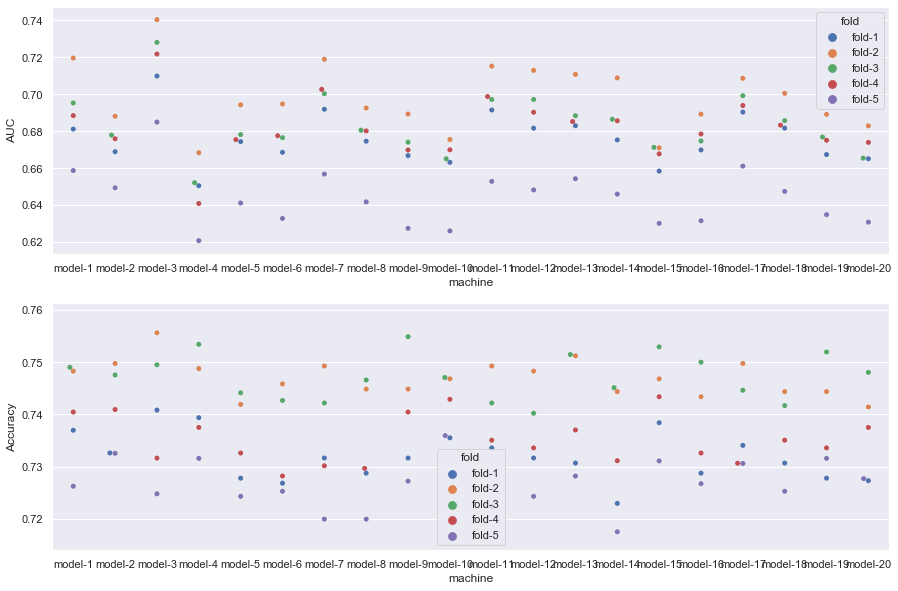

In [34]:
plot_results(toplot_result)

In [35]:
parameters_df[parameters_df.Machine == 'machine-3']

,Machine,n_estimators,max_depth,min_samples_split,min_samples_leaf,rate_aug,sample_aug
2,machine-3,250,35,30,10,1.0,0.9


second try: reduced scope

In [42]:
my_rf_models = list()
number_of_machines = 5
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'n_estimators' : [ 250, 300, 230, 280, 200],
    'max_depth' : [ 35, 30, 28, 25, 30],        
    'min_samples_split' : [ 30, 28, 34, 40, 25], 
    'min_samples_leaf': [ 10, 12, 8, 18, 5 ],
 'rate_aug': [ 1.0, 0.9, 1.0, 1.0, 1.0 ],
 'sample_aug': [ 0.9, 0.9, 0.9, 0.9, 0.9] }

for i in range(number_of_machines):
    n_estimators_param = parameters['n_estimators'][i]
    max_depth_param = parameters['max_depth'][i]
    min_samples_split_param = parameters['min_samples_split'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    
    my_rf = RandomForestClassifier(n_estimators = n_estimators_param , max_depth = max_depth_param, 
                                   min_samples_split = min_samples_split_param, min_samples_leaf = min_samples_leaf_param)
    my_rf_models.append(my_rf)

parameters_df = pd.DataFrame(parameters)

In [45]:
result_tunning = model_fitting_kfold(models = my_rf_models , indexes_kfolds = kfolds_touse, features = features_to_use, train_data = train_section_1_aug,
                           rate_aug = parameters['rate_aug'], sample_aug = parameters['sample_aug'])

done machine 1
done machine 2
done machine 3
done machine 4
done machine 5


In [46]:
toplot_result = jsontotable(result_tunning[0], typex = 'Validation')

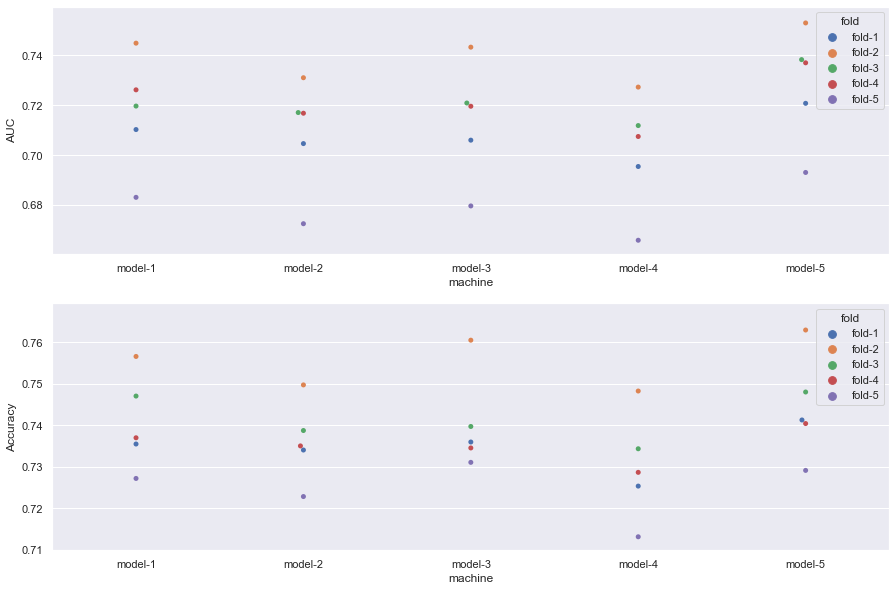

In [47]:
plot_results(toplot_result)

In [49]:
parameters_df[parameters_df.Machine == 'machine-5']

,Machine,n_estimators,max_depth,min_samples_split,min_samples_leaf,rate_aug,sample_aug
4,machine-5,200,30,25,5,1.0,0.9


In [51]:
my_rf_models = list()
number_of_machines = 6
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'n_estimators' : [ 200, 210, 190, 180, 205, 195],
    'max_depth' : [30, 27, 32, 25, 35, 35],        
    'min_samples_split' : [ 25, 24, 21, 29, 35, 20], 
    'min_samples_leaf': [5, 4, 1, 10, 7, 4],
 'rate_aug': [ 1.0 ,1.0, 1.0,1.0, 1.0, 1.0],
 'sample_aug': [ 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,] }

for i in range(number_of_machines):
    n_estimators_param = parameters['n_estimators'][i]
    max_depth_param = parameters['max_depth'][i]
    min_samples_split_param = parameters['min_samples_split'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    
    my_rf = RandomForestClassifier(n_estimators = n_estimators_param , max_depth = max_depth_param, 
                                   min_samples_split = min_samples_split_param, min_samples_leaf = min_samples_leaf_param)
    my_rf_models.append(my_rf)

parameters_df = pd.DataFrame(parameters)

In [52]:
result_tunning = model_fitting_kfold(models = my_rf_models , indexes_kfolds = kfolds_touse, features = features_to_use, train_data = train_section_1_aug,
                           rate_aug = parameters['rate_aug'], sample_aug = parameters['sample_aug'])

done machine 1
done machine 2
done machine 3
done machine 4
done machine 5
done machine 6


In [54]:
toplot_result = jsontotable(result_tunning[0], typex = 'Validation')

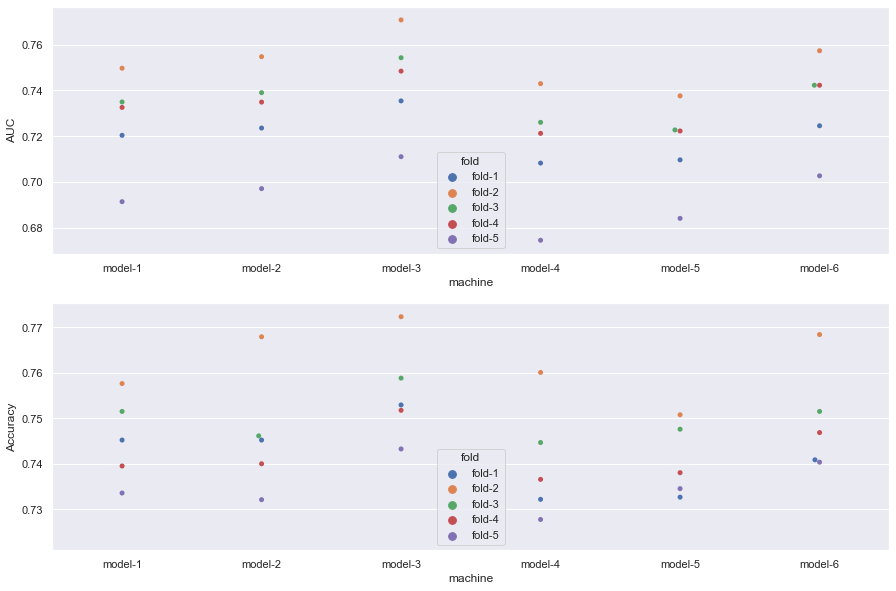

In [55]:
plot_results(toplot_result)

In [56]:
parameters_df[parameters_df.Machine == 'machine-3']

,Machine,n_estimators,max_depth,min_samples_split,min_samples_leaf,rate_aug,sample_aug
2,machine-3,190,32,21,1,1.0,0.9


<b >Final Tunning

In [20]:
my_rf_models = list()
number_of_machines = 6
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'n_estimators' : [ 190, 185, 195, 170, 190, 180],
    'max_depth' : [ 32, 35, 30, 28, 30, 28],        
    'min_samples_split' : [  21, 18, 20, 15, 25, 20], 
    'min_samples_leaf': [ 1, 4, 2, 4, 1, 1],
 'rate_aug': [ 1.0 ,1.0, 1.0,1.0, 1.0, 1.0],
 'sample_aug': [ 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,] }

for i in range(number_of_machines):
    n_estimators_param = parameters['n_estimators'][i]
    max_depth_param = parameters['max_depth'][i]
    min_samples_split_param = parameters['min_samples_split'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    
    my_rf = RandomForestClassifier(n_estimators = n_estimators_param , max_depth = max_depth_param, 
                                   min_samples_split = min_samples_split_param, min_samples_leaf = min_samples_leaf_param)
    my_rf_models.append(my_rf)

parameters_df = pd.DataFrame(parameters)

In [21]:
result_tunning, modelsTrained_section_1 = model_fitting_kfold(models = my_rf_models , indexes_kfolds = kfolds_touse, features = features_to_use, train_data = train_section_1_aug,
                           rate_aug = parameters['rate_aug'], sample_aug = parameters['sample_aug'], save_model = True, save_nro_machine = 1)

done machine 1
done machine 2
done machine 3
done machine 4
done machine 5
done machine 6


In [22]:
toplot_result = jsontotable(result_tunning, typex = 'Validation')

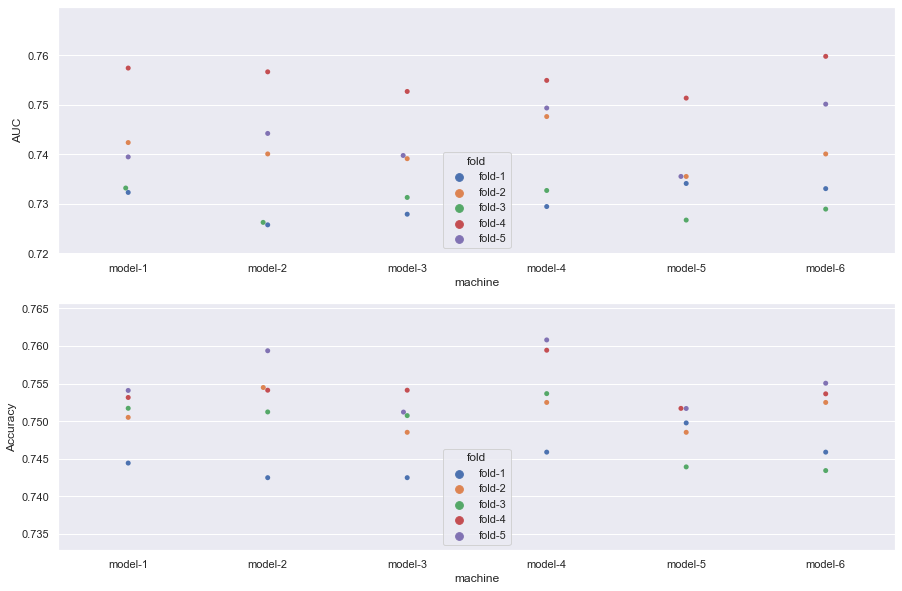

In [23]:
plot_results(toplot_result)

In [24]:
parameters_df[parameters_df.Machine == 'machine-1']

,Machine,n_estimators,max_depth,min_samples_split,min_samples_leaf,rate_aug,sample_aug
0,machine-1,190,32,21,1,1.0,0.9


In [25]:
weight_data = train_section_1_aug[train_section_1_aug.target.isin([0,1])]

In [26]:
weighted_section_1_model = weighting_models(models = modelsTrained_section_1 , features = features_to_use, data = weight_data)
result = weighting_models(models = modelsTrained_section_1 , features = features_to_use, data = weight_data, trained_model = weighted_section_1_model)

In [27]:
roc_auc_score(weight_data.target.values,result)

0.8867964260859975

### Section 2

In [28]:
train_section_2.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    56283
1     6773
Name: mahalanobis, dtype: int64

In [29]:
dict_1 = {'n':7600, 'range': [9,15], 'label': 2, 'rate': 0.65}  #random augmentation
dict_2 = {'n':6000, 'label': 1} # augmetation on existing ones
dict_3 = {'n':6500, 'range': [9,15], 'label': 4, 'category': 2} # augmetation on the previous ones

unscld_train_section_2 =unscaler(train_section_2, scalerx)
train_section_2_aug = augmentation_strategy(data = unscld_train_section_2, dict_1 = dict_1,dict_2 = dict_2, dict_3 = dict_3,
                      gen_mean = means_train, gen_cov = cov_train, columns_features = numerical_features ).reset_index(drop = True)
del unscld_train_section_2
train_section_2_aug =  scaler(train_section_2_aug,scalerx)

In [30]:
train_section_2_aug.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    56283
1     6773
2     7600
3     6000
4     6500
Name: mahalanobis, dtype: int64

In [31]:
train_section_2_aug['mahalanobis'].describe()

count    83156.000000
mean         0.733764
std          0.901687
min         -0.253833
25%          0.077222
50%          0.476140
75%          1.020151
max          3.543129
Name: mahalanobis, dtype: float64

<b> Data splitting strategy

In [32]:
kfolds_touse = k_folds_indexs(train_section_2_aug, folds = 5, balanced = True, validation_additional_false = 1000, validation_reduce_false = 25000)

In [33]:
train_section_2_aug[train_section_2_aug.index.isin(kfolds_touse['fold 3']['train index'])].pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    28941
1     5431
2     7600
3     6000
4     6500
Name: mahalanobis, dtype: int64

In [34]:
len(train_section_2_aug[train_section_2_aug.index.isin(kfolds_touse['fold 3']['train index'])])

54472

<b> tunning strategy

In [35]:
features_to_use = numerical_features + ['mahalanobis']

#### Section 2: Random Forest

First Try: broad search 

In [30]:
my_rf_models = list()
number_of_machines = 20
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'n_estimators' : [100, 500, 250, 1500, 750, 450,150, 250, 350, 450, 850, 950, 440, 550, 660, 370, 900, 330, 440, 510],
    'max_depth' : [15, 20, 35, 20, 10, 45, 25,35, 75, 65, 18, 29, 35, 45, 25, 55, 60, 65, 15, 65],        
    'min_samples_split' : [10, 20, 30, 15, 25, 35, 60, 15, 20, 36, 50, 60, 24, 35, 15, 12, 24, 22, 44, 18], 
    'min_samples_leaf': [4, 6, 10, 2, 20, 35, 12, 30, 18, 10, 14, 8, 10, 22, 17, 32, 8, 15, 26, 35],
 'rate_aug': [0.5, 0.25, 1.0, 0.0, 0.65, 0.48, 0.9, 0.6, 0.2, 0.1, 0.8, 0.6, 0.4, 0.55, 0.10, 0.3, 0.5, 0.44, 0.3, 0.2],
 'sample_aug': [0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7] }

for i in range(number_of_machines):
    n_estimators_param = parameters['n_estimators'][i]
    max_depth_param = parameters['max_depth'][i]
    min_samples_split_param = parameters['min_samples_split'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    
    my_rf = RandomForestClassifier(n_estimators = n_estimators_param , max_depth = max_depth_param, 
                                   min_samples_split = min_samples_split_param, min_samples_leaf = min_samples_leaf_param)
    my_rf_models.append(my_rf)

parameters_df = pd.DataFrame(parameters)  

In [31]:
result_tunning = model_fitting_kfold(models = my_rf_models , indexes_kfolds = kfolds_touse, features = features_to_use, train_data = train_section_2_aug,
                           rate_aug = parameters['rate_aug'], sample_aug = parameters['sample_aug'])

done machine 1
done machine 2
done machine 3
done machine 4
done machine 5
done machine 6
done machine 7
done machine 8
done machine 9
done machine 10
done machine 11
done machine 12
done machine 13
done machine 14
done machine 15
done machine 16
done machine 17
done machine 18
done machine 19
done machine 20


In [32]:
toplot_result = jsontotable(result_tunning[0], typex = 'Validation')

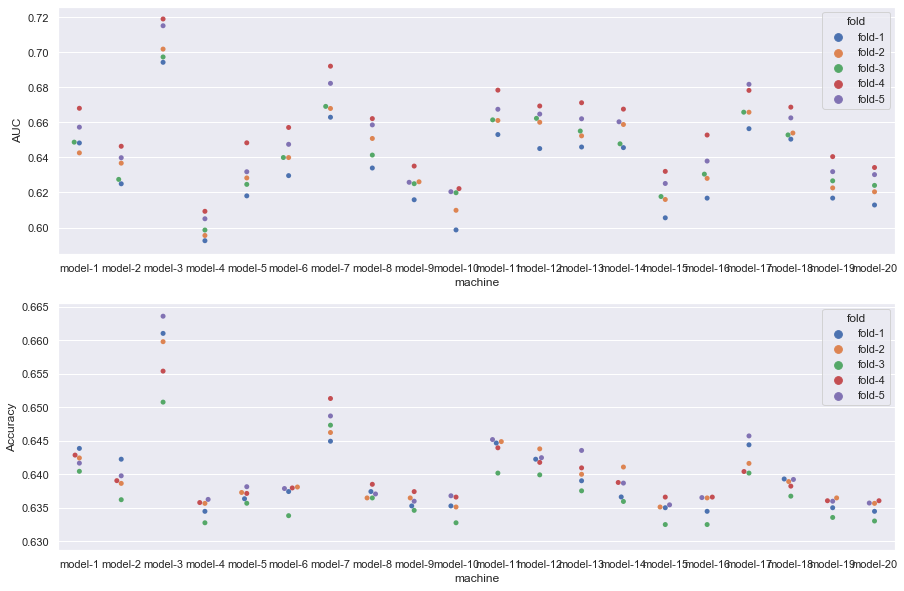

In [33]:
plot_results(toplot_result)

In [34]:
parameters_df[parameters_df.Machine == 'machine-3']

,Machine,n_estimators,max_depth,min_samples_split,min_samples_leaf,rate_aug,sample_aug
2,machine-3,250,35,30,10,1.0,0.7


going further

In [35]:
my_rf_models = list()
number_of_machines = 9
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'n_estimators' : [ 250, 220, 270, 240, 260, 250, 235, 255, 260],
    'max_depth' : [ 35, 30, 30, 40, 44, 35, 35, 32, 30],        
    'min_samples_split' : [ 30, 25, 35, 30, 30, 25, 34, 31, 28 ], 
    'min_samples_leaf': [ 10, 8, 5, 13, 15, 14, 9, 5, 9 ],
 'rate_aug': [ 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0 ],
 'sample_aug': [ 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7] }

for i in range(number_of_machines):
    n_estimators_param = parameters['n_estimators'][i]
    max_depth_param = parameters['max_depth'][i]
    min_samples_split_param = parameters['min_samples_split'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    
    my_rf = RandomForestClassifier(n_estimators = n_estimators_param , max_depth = max_depth_param, 
                                   min_samples_split = min_samples_split_param, min_samples_leaf = min_samples_leaf_param)
    my_rf_models.append(my_rf)

parameters_df = pd.DataFrame(parameters)  

In [36]:
result_tunning = model_fitting_kfold(models = my_rf_models , indexes_kfolds = kfolds_touse, features = features_to_use, train_data = train_section_2_aug,
                           rate_aug = parameters['rate_aug'], sample_aug = parameters['sample_aug'])

done machine 1
done machine 2
done machine 3
done machine 4
done machine 5
done machine 6
done machine 7
done machine 8
done machine 9


In [37]:
toplot_result = jsontotable(result_tunning[0], typex = 'Validation')

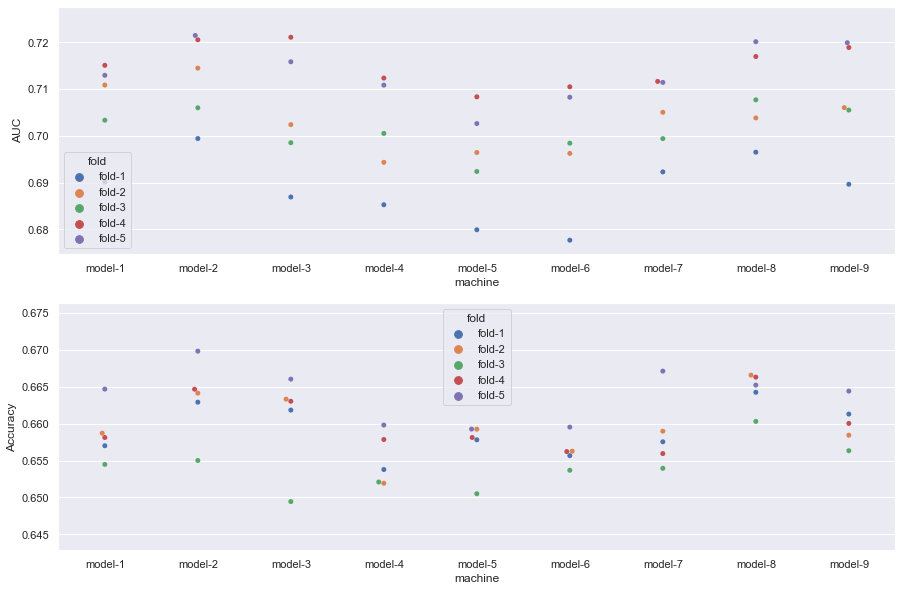

In [38]:
plot_results(toplot_result)

In [39]:
parameters_df[parameters_df.Machine == 'machine-2']

,Machine,n_estimators,max_depth,min_samples_split,min_samples_leaf,rate_aug,sample_aug
1,machine-2,220,30,25,8,1.0,0.7


<b> Final Try

In [36]:
my_rf_models = list()
number_of_machines = 6
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'n_estimators' : [ 220, 200, 220, 210, 230, 230],
    'max_depth' : [  30, 30, 27, 34, 34, 25],        
    'min_samples_split' : [ 25, 30, 26, 20, 24, 22], 
    'min_samples_leaf': [  8, 5, 3, 8, 12, 14],
 'rate_aug': [  1.0, 1.0, 1.0, 1.0, 1.0, 1.0 ],
 'sample_aug': [  0.7,0.7,0.7, 0.7,0.7,0.7] }

for i in range(number_of_machines):
    n_estimators_param = parameters['n_estimators'][i]
    max_depth_param = parameters['max_depth'][i]
    min_samples_split_param = parameters['min_samples_split'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    
    my_rf = RandomForestClassifier(n_estimators = n_estimators_param , max_depth = max_depth_param, 
                                   min_samples_split = min_samples_split_param, min_samples_leaf = min_samples_leaf_param)
    my_rf_models.append(my_rf)

parameters_df = pd.DataFrame(parameters)  

In [37]:
result_tunning, modelsTrained_section_2 = model_fitting_kfold(models = my_rf_models , indexes_kfolds = kfolds_touse, features = features_to_use, train_data = train_section_2_aug,
                           rate_aug = parameters['rate_aug'], sample_aug = parameters['sample_aug'], save_model = True, save_nro_machine = 3)

done machine 1
done machine 2
done machine 3
done machine 4
done machine 5
done machine 6


In [38]:
toplot_result = jsontotable(result_tunning, typex = 'Validation')

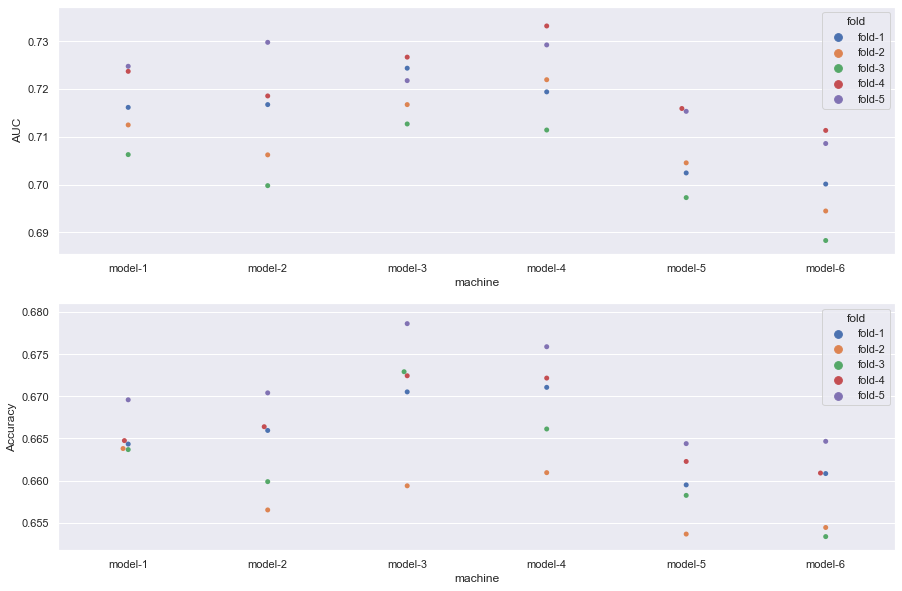

In [39]:
plot_results(toplot_result)

In [40]:
parameters_df[parameters_df.Machine == 'machine-3']

,Machine,n_estimators,max_depth,min_samples_split,min_samples_leaf,rate_aug,sample_aug
2,machine-3,220,27,26,3,1.0,0.7


In [41]:
weight_data = train_section_2_aug[train_section_2_aug.target.isin([0,1])]

In [42]:
weighted_section_2_model = weighting_models(models = modelsTrained_section_2 , features = features_to_use, data = weight_data)
result = weighting_models(models = modelsTrained_section_2 , features = features_to_use, data = weight_data, trained_model = weighted_section_2_model)

In [43]:
roc_auc_score(weight_data.target.values,result)

0.8537904454650317

### Section 3

In [44]:
train_section_3.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    64201
1     5733
Name: mahalanobis, dtype: int64

In [45]:
dict_1 = {'n':7600, 'range': [-50,9], 'label': 2, 'rate': 0.65}  #random augmentation
dict_2 = {'n':5000, 'label': 1} # augmetation on existing ones
dict_3 = {'n':8000, 'range': [-50,9], 'label': 4, 'category': 2} # augmetation on the previous ones

unscld_train_section_3 =unscaler(train_section_3, scalerx)
train_section_3_aug = augmentation_strategy(data = unscld_train_section_3, dict_1 = dict_1,dict_2 = dict_2, dict_3 = dict_3,
                      gen_mean = means_train, gen_cov = cov_train, columns_features = numerical_features ).reset_index(drop = True)
del unscld_train_section_3
train_section_3_aug =  scaler(train_section_3_aug,scalerx)

In [46]:
train_section_3_aug.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    64201
1     5733
2     7600
3     5000
4     8000
Name: mahalanobis, dtype: int64

In [47]:
train_section_3_aug['mahalanobis'].describe()

count    90534.000000
mean        -0.684716
std          0.544812
min         -1.757342
25%         -1.049585
50%         -0.726653
75%         -0.434635
max          1.416823
Name: mahalanobis, dtype: float64

<b> Data splitting strategy

In [48]:
kfolds_touse = k_folds_indexs(train_section_3_aug, folds = 5, balanced = True, validation_additional_false = 4000, validation_reduce_false = 45000)

In [49]:
train_section_3_aug[train_section_3_aug.index.isin(kfolds_touse['fold 3']['train index'])].pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    14033
1     4565
2     7600
3     5000
4     8000
Name: mahalanobis, dtype: int64

In [50]:
len(train_section_3_aug[train_section_3_aug.index.isin(kfolds_touse['fold 3']['train index'])])

39198

<b> tunning strategy

In [51]:
features_to_use = numerical_features + ['mahalanobis']

#### Section 3: Random Forest

First Try: broad search 

In [61]:
my_rf_models = list()
number_of_machines = 20
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'n_estimators' : [100, 500, 250, 1500, 750, 450,150, 250, 350, 450, 850, 950, 440, 550, 660, 370, 900, 330, 440, 510],
    'max_depth' : [15, 20, 35, 20, 10, 45, 25,35, 75, 65, 18, 29, 35, 45, 25, 55, 60, 65, 15, 65],        
    'min_samples_split' : [10, 20, 30, 15, 25, 35, 60, 15, 20, 36, 50, 60, 24, 35, 15, 12, 24, 22, 44, 18], 
    'min_samples_leaf': [4, 6, 10, 2, 20, 35, 12, 30, 18, 10, 14, 8, 10, 22, 17, 32, 8, 15, 26, 35],
 'rate_aug': [0.5, 0.25, 1.0, 0.0, 0.65, 0.48, 0.9, 0.6, 0.2, 0.1, 0.8, 0.6, 0.4, 0.55, 0.10, 0.3, 0.5, 0.44, 0.3, 0.2],
 'sample_aug': [0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7] }

for i in range(number_of_machines):
    n_estimators_param = parameters['n_estimators'][i]
    max_depth_param = parameters['max_depth'][i]
    min_samples_split_param = parameters['min_samples_split'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    
    my_rf = RandomForestClassifier(n_estimators = n_estimators_param , max_depth = max_depth_param, 
                                   min_samples_split = min_samples_split_param, min_samples_leaf = min_samples_leaf_param)
    my_rf_models.append(my_rf)

parameters_df = pd.DataFrame(parameters)  

In [63]:
result_tunning = model_fitting_kfold(models = my_rf_models , indexes_kfolds = kfolds_touse, features = features_to_use, train_data = train_section_3_aug,
                           rate_aug = parameters['rate_aug'], sample_aug = parameters['sample_aug'])

done machine 1
done machine 2
done machine 3
done machine 4
done machine 5
done machine 6
done machine 7
done machine 8
done machine 9
done machine 10
done machine 11
done machine 12
done machine 13
done machine 14
done machine 15
done machine 16
done machine 17
done machine 18
done machine 19
done machine 20


In [64]:
toplot_result = jsontotable(result_tunning[0], typex = 'Validation')

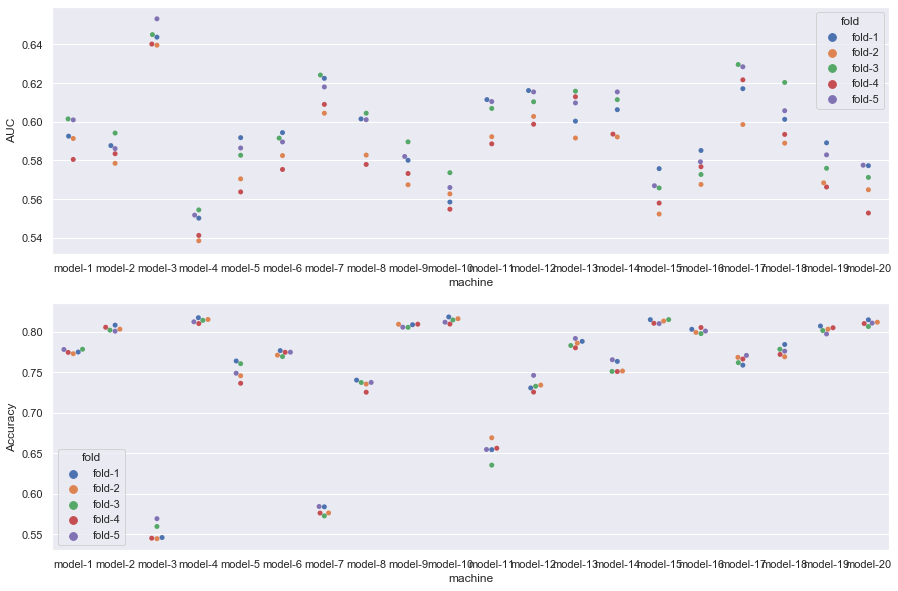

In [65]:
plot_results(toplot_result)

In [73]:
parameters_df[parameters_df.Machine == 'machine-3']

,Machine,n_estimators,max_depth,min_samples_split,min_samples_leaf,rate_aug,sample_aug
2,machine-3,270,30,35,5,1.0,0.7


going further

In [67]:
my_rf_models = list()
number_of_machines = 9
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'n_estimators' : [ 250, 220, 270, 240, 260, 250, 235, 255, 260],
    'max_depth' : [ 35, 30, 30, 40, 44, 35, 35, 32, 30],        
    'min_samples_split' : [ 30, 25, 35, 30, 30, 25, 34, 31, 28 ], 
    'min_samples_leaf': [ 10, 8, 5, 13, 15, 14, 9, 5, 9 ],
 'rate_aug': [ 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0 ],
 'sample_aug': [ 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7] }

for i in range(number_of_machines):
    n_estimators_param = parameters['n_estimators'][i]
    max_depth_param = parameters['max_depth'][i]
    min_samples_split_param = parameters['min_samples_split'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    
    my_rf = RandomForestClassifier(n_estimators = n_estimators_param , max_depth = max_depth_param, 
                                   min_samples_split = min_samples_split_param, min_samples_leaf = min_samples_leaf_param)
    my_rf_models.append(my_rf)

parameters_df = pd.DataFrame(parameters)  

In [68]:
result_tunning = model_fitting_kfold(models = my_rf_models , indexes_kfolds = kfolds_touse, features = features_to_use, train_data = train_section_3_aug,
                           rate_aug = parameters['rate_aug'], sample_aug = parameters['sample_aug'])

done machine 1
done machine 2
done machine 3
done machine 4
done machine 5
done machine 6
done machine 7
done machine 8
done machine 9


In [69]:
toplot_result = jsontotable(result_tunning[0], typex = 'Validation')

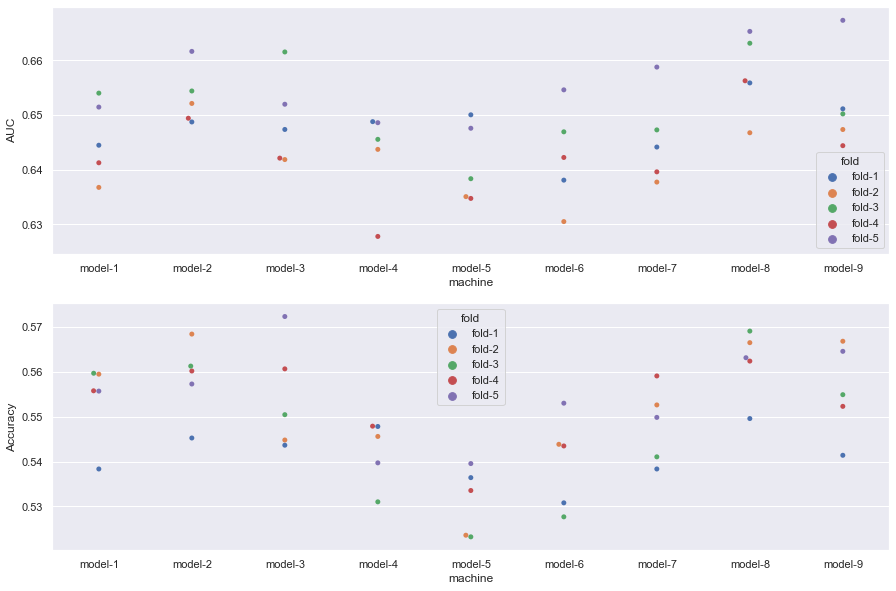

In [70]:
plot_results(toplot_result)

In [74]:
parameters_df[parameters_df.Machine == 'machine-8']

,Machine,n_estimators,max_depth,min_samples_split,min_samples_leaf,rate_aug,sample_aug
7,machine-8,255,32,31,5,1.0,0.7


<b> Final Try

In [52]:
my_rf_models = list()
number_of_machines = 6
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'n_estimators' : [ 255, 245, 250, 265, 260, 245],
    'max_depth' : [ 32, 35, 28, 30, 35, 31],        
    'min_samples_split' : [ 31, 26, 37, 37, 29, 33], 
    'min_samples_leaf': [ 5, 1, 1, 5, 5, 9],
 'rate_aug': [ 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'sample_aug': [  0.7, 0.7, 0.7, 0.7, 0.7, 0.7] }

for i in range(number_of_machines):
    n_estimators_param = parameters['n_estimators'][i]
    max_depth_param = parameters['max_depth'][i]
    min_samples_split_param = parameters['min_samples_split'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    
    my_rf = RandomForestClassifier(n_estimators = n_estimators_param , max_depth = max_depth_param, 
                                   min_samples_split = min_samples_split_param, min_samples_leaf = min_samples_leaf_param)
    my_rf_models.append(my_rf)

parameters_df = pd.DataFrame(parameters)  

In [53]:
result_tunning,  modelsTrained_section_3 = model_fitting_kfold(models = my_rf_models , indexes_kfolds = kfolds_touse, features = features_to_use, train_data = train_section_3_aug,
                           rate_aug = parameters['rate_aug'], sample_aug = parameters['sample_aug'], save_model = True, save_nro_machine = 2)

done machine 1
done machine 2
done machine 3
done machine 4
done machine 5
done machine 6


In [54]:
toplot_result = jsontotable(result_tunning, typex = 'Validation')

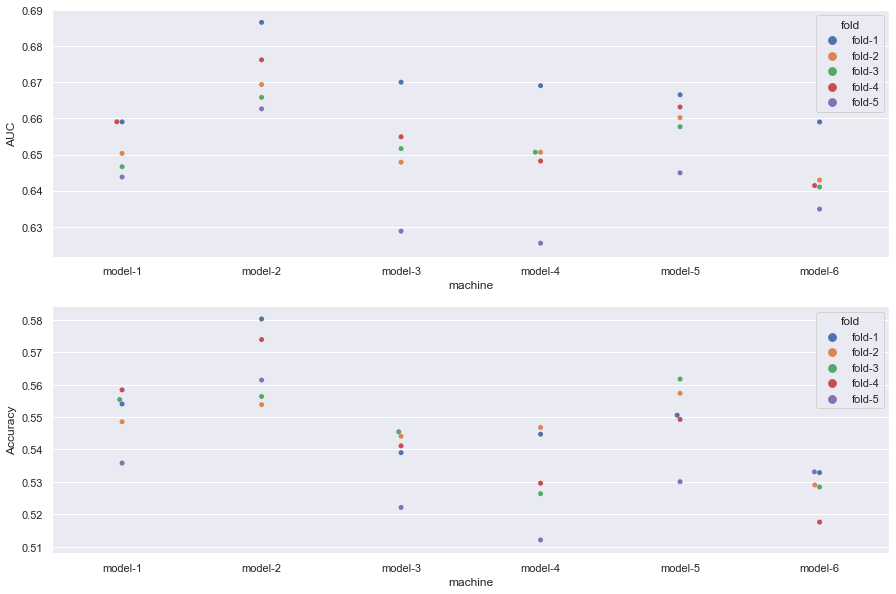

In [55]:
plot_results(toplot_result)

In [56]:
parameters_df[parameters_df.Machine == 'machine-2']

,Machine,n_estimators,max_depth,min_samples_split,min_samples_leaf,rate_aug,sample_aug
1,machine-2,245,35,26,1,1.0,0.7


In [57]:
weight_data = train_section_3_aug[train_section_3_aug.target.isin([0,1])]

In [58]:
weighted_section_3_model = weighting_models(models = modelsTrained_section_3 , features = features_to_use, data = weight_data)
result = weighting_models(models = modelsTrained_section_3 , features = features_to_use, data = weight_data, trained_model = weighted_section_3_model)

In [59]:
roc_auc_score(weight_data.target.values,result)

0.8175284101760547

#### Fast Training:

In [12]:
features_to_use = numerical_features + ['mahalanobis']

In [13]:
dict_1 = {'n':3600, 'range': [15,40], 'label': 2, 'rate': 0.65}  #random augmentation
dict_2 = {'n':2000, 'label': 1} # augmetation on existing ones
dict_3 = {'n':4000, 'range': [15,40], 'label': 4, 'category': 2} # augmetation on the previous ones

unscld_train_section_1 =unscaler(train_section_1, scalerx)
train_section_1_aug = augmentation_strategy(data = unscld_train_section_1, dict_1 = dict_1,dict_2 = dict_2, dict_3 = dict_3,
                      gen_mean = means_train, gen_cov = cov_train, columns_features = numerical_features ).reset_index(drop = True)
del unscld_train_section_1
train_section_1_aug =  scaler(train_section_1_aug,scalerx)

In [14]:
kfolds_touse_1 = k_folds_indexs(train_section_1_aug, folds = 5, balanced = True, validation_additional_false = 1000, validation_reduce_false = 6000)

In [15]:
dict_1 = {'n':7600, 'range': [9,15], 'label': 2, 'rate': 0.65}  #random augmentation
dict_2 = {'n':6000, 'label': 1} # augmetation on existing ones
dict_3 = {'n':6500, 'range': [9,15], 'label': 4, 'category': 2} # augmetation on the previous ones

unscld_train_section_2 =unscaler(train_section_2, scalerx)
train_section_2_aug = augmentation_strategy(data = unscld_train_section_2, dict_1 = dict_1,dict_2 = dict_2, dict_3 = dict_3,
                      gen_mean = means_train, gen_cov = cov_train, columns_features = numerical_features ).reset_index(drop = True)
del unscld_train_section_2
train_section_2_aug =  scaler(train_section_2_aug,scalerx)

In [16]:
kfolds_touse_2 = k_folds_indexs(train_section_2_aug, folds = 5, balanced = True, validation_additional_false = 1000, validation_reduce_false = 25000)

In [18]:
dict_1 = {'n':8600, 'range': [-50,9], 'label': 2, 'rate': 0.65}  #random augmentation
dict_2 = {'n':7000, 'label': 1} # augmetation on existing ones
dict_3 = {'n':8000, 'range': [-50,9], 'label': 4, 'category': 2} # augmetation on the previous ones

unscld_train_section_3 =unscaler(train_section_3, scalerx)
train_section_3_aug = augmentation_strategy(data = unscld_train_section_3, dict_1 = dict_1,dict_2 = dict_2, dict_3 = dict_3,
                      gen_mean = means_train, gen_cov = cov_train, columns_features = numerical_features ).reset_index(drop = True)
del unscld_train_section_3
train_section_3_aug =  scaler(train_section_3_aug,scalerx)

In [19]:
kfolds_touse_3 = k_folds_indexs(train_section_3_aug, folds = 5, balanced = True, validation_additional_false = 4000, validation_reduce_false = 45000)

section 1 

In [20]:
my_rf_models = list()
number_of_machines = 1
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'n_estimators' : [ 190,],
    'max_depth' : [ 32,],        
    'min_samples_split' : [  21,], 
    'min_samples_leaf': [ 1,],
 'rate_aug': [ 1.0, ],
 'sample_aug': [ 0.9,] }

for i in range(number_of_machines):
    n_estimators_param = parameters['n_estimators'][i]
    max_depth_param = parameters['max_depth'][i]
    min_samples_split_param = parameters['min_samples_split'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    
    my_rf = RandomForestClassifier(n_estimators = n_estimators_param , max_depth = max_depth_param, 
                                   min_samples_split = min_samples_split_param, min_samples_leaf = min_samples_leaf_param)
    my_rf_models.append(my_rf)

parameters_df = pd.DataFrame(parameters)

In [21]:
result_tunning, modelsTrained_section_1 = model_fitting_kfold(models = my_rf_models , indexes_kfolds = kfolds_touse_1, features = features_to_use, train_data = train_section_1_aug,
                           rate_aug = parameters['rate_aug'], sample_aug = parameters['sample_aug'], save_model = True, save_nro_machine = 1)

done machine 1


In [22]:
weight_data = train_section_1_aug[train_section_1_aug.target.isin([0,1])]

In [23]:
weighted_section_1_model = weighting_models(models = modelsTrained_section_1 , features = features_to_use, data = weight_data)
result = weighting_models(models = modelsTrained_section_1 , features = features_to_use, data = weight_data, trained_model = weighted_section_1_model)

section 2 

In [25]:
my_rf_models = list()
number_of_machines = 1
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'n_estimators' : [ 220,] ,
    'max_depth' : [ 27, ],        
    'min_samples_split' : [ 26], 
    'min_samples_leaf': [ 3,],
 'rate_aug': [ 1.0,],
 'sample_aug': [ 0.7,] }

for i in range(number_of_machines):
    n_estimators_param = parameters['n_estimators'][i]
    max_depth_param = parameters['max_depth'][i]
    min_samples_split_param = parameters['min_samples_split'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    
    my_rf = RandomForestClassifier(n_estimators = n_estimators_param , max_depth = max_depth_param, 
                                   min_samples_split = min_samples_split_param, min_samples_leaf = min_samples_leaf_param)
    my_rf_models.append(my_rf)

parameters_df = pd.DataFrame(parameters)  

In [26]:
result_tunning, modelsTrained_section_2 = model_fitting_kfold(models = my_rf_models , indexes_kfolds = kfolds_touse_2, features = features_to_use, train_data = train_section_2_aug,
                           rate_aug = parameters['rate_aug'], sample_aug = parameters['sample_aug'], save_model = True, save_nro_machine = 1)

done machine 1


In [27]:
weight_data = train_section_2_aug[train_section_2_aug.target.isin([0,1])]

In [28]:
weighted_section_2_model = weighting_models(models = modelsTrained_section_2 , features = features_to_use, data = weight_data)
result = weighting_models(models = modelsTrained_section_2 , features = features_to_use, data = weight_data, trained_model = weighted_section_2_model)

section 3

In [29]:
my_rf_models = list()
number_of_machines = 1
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'n_estimators' : [245],
    'max_depth' : [35],        
    'min_samples_split' : [26], 
    'min_samples_leaf': [ 5],
 'rate_aug': [1.0],
 'sample_aug': [0.7] }

for i in range(number_of_machines):
    n_estimators_param = parameters['n_estimators'][i]
    max_depth_param = parameters['max_depth'][i]
    min_samples_split_param = parameters['min_samples_split'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    
    my_rf = RandomForestClassifier(n_estimators = n_estimators_param , max_depth = max_depth_param, 
                                   min_samples_split = min_samples_split_param, min_samples_leaf = min_samples_leaf_param)
    my_rf_models.append(my_rf)

parameters_df = pd.DataFrame(parameters)  

In [30]:
result_tunning,  modelsTrained_section_3 = model_fitting_kfold(models = my_rf_models , indexes_kfolds = kfolds_touse_3, features = features_to_use, train_data = train_section_3_aug,
                           rate_aug = parameters['rate_aug'], sample_aug = parameters['sample_aug'], save_model = True, save_nro_machine = 1)

done machine 1


In [31]:
weight_data = train_section_3_aug[train_section_3_aug.target.isin([0,1])]

In [32]:
weighted_section_3_model = weighting_models(models = modelsTrained_section_3 , features = features_to_use, data = weight_data)
result = weighting_models(models = modelsTrained_section_3 , features = features_to_use, data = weight_data, trained_model = weighted_section_3_model)

### Testing on validation

bagging and consolidation with logistic regression

In [33]:
validation_dataset = validation_dataset[ ['target'] + numerical_features]
validation_dataset_distance = compute_mahalanobis_parts(validation_dataset, numerical_features, 20000,[True,True], means_train, cov_train )
validation_dataset_scaled = scaler(validation_dataset_distance, scalerx)

In [34]:
validation_section_1, validation_section_2, validation_section_3 = partitions(validation_dataset_scaled)

In [35]:
target_vector = np.concatenate((validation_section_1.target.values, validation_section_2.target.values, validation_section_3.target.values), axis=None)

In [36]:
predictions_val_section1 = weighting_models(models = modelsTrained_section_1 , features = features_to_use, data = validation_section_1, trained_model = weighted_section_1_model)
predictions_val_section2 = weighting_models(models = modelsTrained_section_2 , features = features_to_use, data = validation_section_2, trained_model = weighted_section_2_model)
predictions_val_section3 = weighting_models(models = modelsTrained_section_3 , features = features_to_use, data = validation_section_3, trained_model = weighted_section_3_model)
vector_predictions = np.concatenate((predictions_val_section1, predictions_val_section2, predictions_val_section3), axis=None)

In [37]:
roc_auc_score(target_vector, vector_predictions)

0.7859031906806018

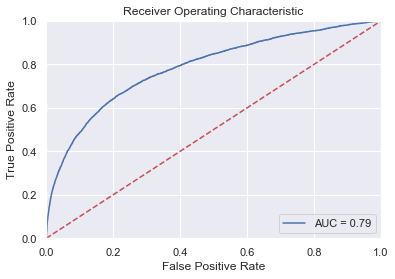

In [38]:
fpr, tpr, threshold = roc_curve(target_vector, vector_predictions)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [39]:
result_validation = reconstructing_data([validation_section_1, validation_section_2, validation_section_3], [predictions_val_section1, predictions_val_section2, predictions_val_section3])

In [40]:
result_validation.head()

,target,var_4,var_12,var_46,var_78,var_81,mahalanobis
0,1,0.316356,-1.508938,-0.052114,0.991112,-0.566750,-0.478052
1,0,0.547758,-0.665887,-0.065743,1.166426,-0.501709,-0.942296
2,0,0.784832,-0.189335,-0.089332,-1.417152,-0.261905,-0.798555
3,0,-0.309164,1.031272,-0.225729,-0.655046,2.067391,0.300614
4,0,-0.105631,0.688470,0.593702,-0.615033,0.564877,-1.230873


### Prediction

In [41]:
test_target = test.assign(target = 0)
test_dataset = test_target[ ['target'] + numerical_features].copy()
test_dataset_distance = compute_mahalanobis_parts(test_dataset, numerical_features, 20000,[True,True], means_train, cov_train )
test_dataset_scaled = scaler(test_dataset_distance, scalerx)

In [42]:
test_section_1, test_section_2, test_section_3 = partitions(test_dataset_scaled)

In [43]:
target_vector = np.concatenate((test_section_1.target.values, test_section_2.target.values, test_section_3.target.values), axis=None)

In [44]:
predictions_test_section1 = weighting_models(models = modelsTrained_section_1 , features = features_to_use, data = test_section_1, trained_model = weighted_section_1_model)
predictions_test_section2 = weighting_models(models = modelsTrained_section_2 , features = features_to_use, data = test_section_2, trained_model = weighted_section_2_model)
predictions_test_section3 = weighting_models(models = modelsTrained_section_3 , features = features_to_use, data = test_section_3, trained_model = weighted_section_3_model)
vector_predictions = np.concatenate((predictions_test_section1, predictions_test_section2, predictions_test_section3), axis=None)

In [45]:
vector_predictions

array([0.03991994, 0.02031838, 0.02038393, ..., 0.04284247, 0.07687867,
       0.00982954])

In [46]:
vector_predictions.shape

(200000,)

In [66]:
test['target'] = vector_predictions
#test['target'] = np.where(test['target'] >0.07, 1, 0)

In [67]:
test.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,target
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197,0.039920
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760,0.020318
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794,0.020384
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108,0.013757
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846,0.058317


In [68]:
test[['ID_code','target']].set_index('ID_code').to_csv('my_prediction.csv')